## Music-selectivity in DNN

In [35]:
# Common
import numpy as np
import matplotlib.pyplot as plt
import os; cwd = os.getcwd()
import os.path as osp
from argparse import Namespace
from tqdm.notebook import tqdm
import random
import seaborn as sns
import numpy.matlib
import matplotlib.pyplot as plt
import os
import os.path as osp
import pickle
plt.rcParams['svg.fonttype'] = 'none'

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split, Dataset
import torchaudio as ta

# etc
from audioset import AudioSet, AudioSet2, AudioSet_shuffle
from imresize import *

# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score, brier_score_loss, \
    log_loss, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, r2_score

use_cuda = torch.cuda.is_available()
torch.manual_seed(7)


In [3]:
opt = Namespace()
opt.batch_size = 32
opt.epochs = 30
opt.lr = 0.001 # 0.001
opt.device = torch.device("cuda" if use_cuda else "cpu")
opt.name = 'cnn_audioset_nomusic'
dr = 0.2 # dropout rate

In [4]:
def binarizer(idx):
    tmp = torch.zeros(num_class)
    tmp[idx] = 1
    return tmp
def collate_fn(batch):
    waveforms = pad_sequence(
        [torch.from_numpy(b[0]).float() for b in batch], 
        batch_first=True)
    waveforms = waveforms.reshape(waveforms.shape[0], 1, -1)
    targets = torch.stack([binarizer(b[1]) for b in batch])
    return waveforms, targets
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

#### Loading data for training

In [5]:
tmpset = AudioSet('data/AudioSet/', train=False)
classes = tmpset.idx2class
reverse_dict= dict(map(reversed,classes.items()))
Musicrelatedind = []
Omittedclasses = []
Music_categories = np.load('Music_categories.npy').tolist()
for key1 in Music_categories:
    if key1 in reverse_dict:
        Musicrelatedind.append(reverse_dict[key1])
    else:
        Omittedclasses.append(key1)


In [6]:
# deleteidx = None ## training all data
deleteidx = Musicrelatedind ## training without music

testset = AudioSet2('data/AudioSet/', train=False, deleteidx= deleteidx)
dataset = AudioSet2('data/AudioSet/', train=True, deleteidx= deleteidx)
trainset, validset = random_split(dataset, [round(len(dataset)*.9), round(len(dataset)*.1)])
num_class = testset.n_class
bs = opt.batch_size
n_workers = 0
isshufflelabel = 0

val_loader = torch.utils.data.DataLoader(
    validset,
    batch_size=bs, shuffle=True, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=bs, shuffle=True, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=bs, shuffle=True, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)

In [7]:
dataiter = iter(val_loader)
wavtmp, labels = dataiter.next()
samplingrate = wavtmp.shape[2]/10 # samplingrate, total 10 s
winlen = int(np.round(samplingrate*1/40))

mel_spectrogram = nn.Sequential(
    ta.transforms.MelSpectrogram(n_mels=64, sample_rate = samplingrate, win_length = winlen, n_fft = winlen, f_min = 0, f_max = 8000, normalized=False),
    ta.transforms.AmplitudeToDB()
)

#### CNN model

In [8]:

class AudioCNN(nn.Module):
    def __init__(self, num_class):
        super(AudioCNN,self).__init__()

        self.spec = mel_spectrogram
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=(2, 4), bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dr),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5,stride=1, bias = False),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,stride=1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(dr),
        )
            
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dr),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dr),
        )
        
        self.fc2 = nn.Linear(256, num_class)
        
    def forward(self, x):
        x = self.spec(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(self.avgpool(x), 1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x 
    

#### Network training

In [10]:
def train(opt, model, train_loader, optim, scheduler, criterion, epoch):
    
    model.train()
    train_loss = 0; total = 0; total_correct = 0
    for inputs, targets in train_loader:
        inputs,targets = inputs.to(opt.device), targets.to(opt.device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        scheduler.step()
        train_loss += loss.item()
        total += targets.size(0)
    
        outputs = torch.sigmoid(outputs)

        with torch.no_grad():
            target = targets.cpu().detach().numpy().flatten()
            output = outputs.cpu().detach().numpy().flatten()
            total_correct += metrics.average_precision_score(target, output, average='micro')

    acc = 100. * total_correct/ len(train_loader) #total
    accuracies_tr.append(acc)

#     print("Train Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1, train_loss/len(train_loader), acc))


    
def validate(opt, model, test_loader, criterion, epoch):
    global best_acc
    model.eval()
    test_loss, total, total_correct, = 0,0,0
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(opt.device), targets.to(opt.device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        total += targets.size(0)
        outputs = torch.sigmoid(outputs)
        with torch.no_grad():
            target = targets.cpu().detach().numpy().flatten()
            output = outputs.cpu().detach().numpy().flatten()
            total_correct += metrics.average_precision_score(target, output, average='micro')
    # Save checkpoint when best model
    acc = 100. * total_correct / len(test_loader) #total
    accuracies_val.append(acc)
   
    print("Validation Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1, test_loss/len(test_loader), acc))
    

    if acc > best_acc:
        if isinstance(model, torch.nn.DataParallel):
            print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                'model':model.module.state_dict(),
                'model1': model.state_dict(),
                'model2': model,
                'acc':acc,
                'epoch':epoch,
                'loss':loss,
            }
        
        else:
            print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                    'model':model,
                    'acc':acc,
                    'epoch':epoch,
                    }      
            
        if not osp.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point + opt.name + '.t7')
        best_acc = acc
    return best_acc

In [11]:
iterind = 0
np.seterr(divide='ignore', invalid='ignore')
torch.manual_seed(iterind)
best_acc = 0
accuracies_tr = []
accuracies_val = []
model = AudioCNN(num_class)
model = model.to(opt.device)

if isinstance(model, torch.nn.DataParallel):
    print('Save random model')
    state = {
        'model':model.module.state_dict(),
        'model1': model.state_dict(),
        'model2': model,
    }
else:
    print('Save random model')
    state = {
            'model':model,
            }      

if not osp.isdir('checkpoint'):
    os.mkdir('checkpoint')
save_point = './checkpoint/'
if not os.path.isdir(save_point):
    os.mkdir(save_point)
torch.save(state, save_point + opt.name + 'rand.t7')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=opt.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=opt.epochs,
                                              anneal_strategy='linear')
for epoch in tqdm(range(opt.epochs)):
    train(opt, model, train_loader, optimizer, scheduler, criterion, epoch)
    best_acc = validate(opt, model, val_loader, criterion, epoch)

Save random model


/home/kdkyum/.anaconda3/envs/audio/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/kdkyum/.anaconda3/envs/audio/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Validation Epoch: [1]  loss: [0.02] Accuracy [9.13] 
Saving Best model...			Top1 = 9.13%
Validation Epoch: [2]  loss: [0.02] Accuracy [11.10] 
Saving Best model...			Top1 = 11.10%
Validation Epoch: [3]  loss: [0.02] Accuracy [12.40] 
Saving Best model...			Top1 = 12.40%
Validation Epoch: [4]  loss: [0.02] Accuracy [12.83] 
Saving Best model...			Top1 = 12.83%
Validation Epoch: [5]  loss: [0.02] Accuracy [12.83] 
Saving Best model...			Top1 = 12.83%
Validation Epoch: [6]  loss: [0.02] Accuracy [14.12] 
Saving Best model...			Top1 = 14.12%
Validation Epoch: [7]  loss: [0.02] Accuracy [12.88] 
Validation Epoch: [8]  loss: [0.02] Accuracy [15.66] 
Saving Best model...			Top1 = 15.66%
Validation Epoch: [9]  loss: [0.02] Accuracy [10.18] 
Validation Epoch: [10]  loss: [0.02] Accuracy [14.04] 
Validation Epoch: [11]  loss: [0.02] Accuracy [13.88] 
Validation Epoch: [12]  loss: [0.02] Accuracy [15.06] 
Validation Epoch: [13]  loss: [0.02] Accuracy [13.37] 
Validation Epoch: [14]  loss: [0.02] 

#### Loading Data for testing music-selectivity

In [12]:
testset = AudioSet('data/AudioSet/', train=False)
dataset = AudioSet('data/AudioSet/', train=True)
trainset, validset = random_split(dataset, [round(len(dataset)*.9), round(len(dataset)*.1)])
num_class = testset.n_class
bs = opt.batch_size
n_workers = 0

val_loader = torch.utils.data.DataLoader(
    validset,
    batch_size=bs, shuffle=False, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=bs, shuffle=False, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=bs, shuffle=False, collate_fn=collate_fn,
    num_workers=n_workers, pin_memory=False)

labelismusic = np.array([True if i in Musicrelatedind else False for i in range(527)])

#### Testing natural sound recognition performance

In [14]:
class Evaluator(object):
    def __init__(self, model):

        self.model = model
        
    def evaluate(self, data_loader):

        clipwise_output = []
        target = []

        for inputs, targets in data_loader:
            inputs, targets = inputs.to(opt.device), targets.to(opt.device)
            outputs = self.model(inputs)
            outputs = torch.sigmoid(outputs)
            if len(clipwise_output) ==0:
                clipwise_output = outputs
                target = targets
            else:
                clipwise_output = torch.cat((clipwise_output, outputs), dim=0)
                target = torch.cat((target, targets), dim=0)
        clipwise_output = clipwise_output.cpu()
        target = target.cpu()
        average_precision = metrics.average_precision_score(
            target, clipwise_output, average=None)
    
        statistics = {'average_precision': average_precision, 'output':clipwise_output}

        return statistics
    
    def evaluate_chance(self, data_loader):
        clipwise_output = []
        target = []

        for inputs, targets in data_loader:
            inputs, targets = inputs.to(opt.device), targets.to(opt.device)
            outputs = self.model(inputs)
            outputs = torch.sigmoid(outputs)
            if len(clipwise_output) ==0:
                clipwise_output = outputs
                target = targets
            else:
                clipwise_output = torch.cat((clipwise_output, outputs), dim=0)
                target = torch.cat((target, targets), dim=0)
        clipwise_output = clipwise_output.cpu()*0+1
        
        target = target.cpu()
        average_precision = metrics.average_precision_score(
            target, clipwise_output, average=None)

        statistics = {'average_precision': average_precision, 'output':clipwise_output}

        return statistics

In [15]:
%%time

checkpoint = torch.load('checkpoint/' + 'cnn_audioset_nomusic' + '.t7')
model = checkpoint['model']
model.eval() # evaluation mode

# Get test statistics
evaluator = Evaluator(model=model)
with torch.no_grad():
    test_statistics = evaluator.evaluate(test_loader)
# chance
evaluator = Evaluator(model=model)
with torch.no_grad():
    test_statistics_chance = evaluator.evaluate_chance(test_loader)

print('Net:trained without music, nonmusic detection performance')
print('mean'+ u"\u00B1" + 'std: mean average precision = ' + str(np.mean(test_statistics['average_precision'][~labelismusic]))) 
print('chance mAP = ' + str(np.mean(test_statistics_chance['average_precision'][~labelismusic])))

print('Net:trained without music, music detection performance')
print('mean'+ u"\u00B1" + 'std: mean average precision = ' + str(np.mean(test_statistics['average_precision'][labelismusic]))) 
print('chance mAP = ' + str(np.mean(test_statistics_chance['average_precision'][labelismusic])))

    

Net:trained without music, nonmusic detection performance
mean±std: mean average precision = 0.12036421862053658
chance mAP = 0.004525523132575321
Net:trained without music, music detection performance
mean±std: mean average precision = 0.007780103318848394
chance mAP = 0.00564257252448516
CPU times: user 3min 40s, sys: 25.1 s, total: 4min 5s
Wall time: 5min 16s


#### Extracting feature vectors

In [16]:

LOI = 'avgpool' # feature extraction layer
def get_module(model, name):
    sub_module = model
    for n in name.split('.'):
        sub_module = sub_module._modules[n]
    return sub_module

# get feature vectors from trained/random network
def get_feature(model, data_loader):
    with torch.no_grad():
        ismusiclabel = []
        isnonmusiclabel = []

        featuretmp = []
        for inputs, targets in data_loader:
            for i in np.arange(targets.shape[0]):
                ismusiclabel.append(not any(np.logical_not([x in Musicrelatedind for x in np.where(targets[i, :])[0]])))
                isnonmusiclabel.append(not any(([x in Musicrelatedind for x in np.where(targets[i, :])[0]])))
                
            x = inputs[:,:,:].float().to(opt.device)
            features_blobs = {}
            hooks = []
            layers = [LOI]
            for layer in layers:
                m = get_module(model, layer)
                def hook_feature(layer):
                    def _hook(module, input, output):
                        features_blobs[layer] = output.detach().cpu().numpy()
                    return _hook
                hooks.append(m.register_forward_hook(hook_feature(layer)))

            with torch.no_grad():
                model(x)
                for hook in hooks:
                    hook.remove()
            fvtmp = features_blobs[LOI] # Activation
            if len(featuretmp)==0:
                featuretmp = fvtmp
            else:    
                featuretmp = np.concatenate((featuretmp, fvtmp), axis = 0)
        featuretmp = np.squeeze(featuretmp)
        ismusic = np.array(ismusiclabel) 
        isnonmusic = np.array(isnonmusiclabel)
        fv = {}
        fv['fv'] = featuretmp
        fv['ismusic'] = ismusic
        fv['isnonmusic'] = isnonmusic

        return fv    

#### Defining Segregation Index

In [17]:
## Analysis of tSNE space
isBC = True 
def getMSI(points, ismusic, isnonmusic, BC = False):
    nbin = 64
    xs = points[:,0]
    ys = points[:,1]
    xmin = np.min(xs)
    xmax = np.max(xs)
    ymin = np.min(ys)
    ymax = np.max(ys)
    rg = [[xmin, xmax], [ymin, ymax]]
    Hmusic, xedges, yedges = np.histogram2d(xs[ismusic], ys[ismusic], bins = nbin, density = True)
    Hnonmusic, xedges, yedges = np.histogram2d(xs[isnonmusic], ys[isnonmusic], bins = nbin, density = True)
    Hmusic = Hmusic/np.sum(Hmusic)
    Hnonmusic = Hnonmusic/np.sum(Hnonmusic)
    BC = (np.sum(np.sqrt(Hmusic*Hnonmusic)))
    SI = 1-BC
    return SI


#### Visualizing tSNE embedding

In [28]:
# Visualization of tSNE embedding: music vs nonmusic
bline = 0.1
cherry = np.array([139, 0, 0, 255*bline])/255 # actually dark red
sapphire = np.array([0, 0,128, 255*bline])/255 # navy
import matplotlib.patches as  mpatches
def tSNE_visualization(name, isA, isnonA, isscatter = False, label1 = 'Music', label2 = 'Non-music'):

    fv = featurevectors[name]['fv']
    ismusic = isA
    isnonmusic = isnonA
    points = embeddings['method:TSNE, ' + name]
    xs = points[:,0]
    ys = points[:,1]
    
    fig = plt.figure() #(figsize = cm2inch(4.2, 4.2))
    levels = np.array([0.2, 0.4, 0.6, 0.8])
    for level in levels:
        sns.kdeplot(x=xs[ismusic], y=ys[ismusic], shade=False, bw_adjust=1, levels = [level], color = level*np.array([0,0,0,1-bline])+cherry)
        sns.kdeplot(x=xs[isnonmusic], y=ys[isnonmusic], shade=False, bw_adjust=1, levels = [level], color = level*np.array([0,0,0,1-bline])+sapphire)

    handles = [mpatches.Patch(facecolor=np.array([139, 0, 0, 180])/255, label=label1),
       mpatches.Patch(facecolor=np.array([0, 0,128, 180])/255, label=label2)]
#     plt.legend(handles=handles, bbox_to_anchor=(0.95, 0.95, 0.3, 0.2), loc='upper right')
    plt.legend(handles=handles)
#         plt.xticks(fontsize = 6)
#         plt.yticks(fontsize = 6)
    plt.xticks(np.arange(-50, 51, 50), labels=['-50', '0', '50'])
    plt.yticks(np.arange(-50, 51, 50), labels=['-50', '0', '50'])

    SI = getMSI(points, ismusic, isnonmusic, BC = isBC)
    print('SI = ' + str(SI))
    return SI


In [19]:
%%time
checkpoint = torch.load('checkpoint/' + 'cnn_audioset_nomusic' + '.t7')
model = checkpoint['model']
model.eval() # evaluation mode
featurevectors = {} 
key_test = 'data:test, net:trained_nomusic'
key_train = 'data:train, net:trained_nomusic'
featurevectors[key_test] = get_feature(model, test_loader) # tuple: fv, ismusic, isnonmusic, isspeech
featurevectors[key_train] = get_feature(model, train_loader) # tuple: fv, ismusic, isnonmusic, isspeech


CPU times: user 3min 41s, sys: 9.68 s, total: 3min 50s
Wall time: 4min 49s


SI = 0.7080531271550826
CPU times: user 5min 29s, sys: 328 ms, total: 5min 30s
Wall time: 3min 54s


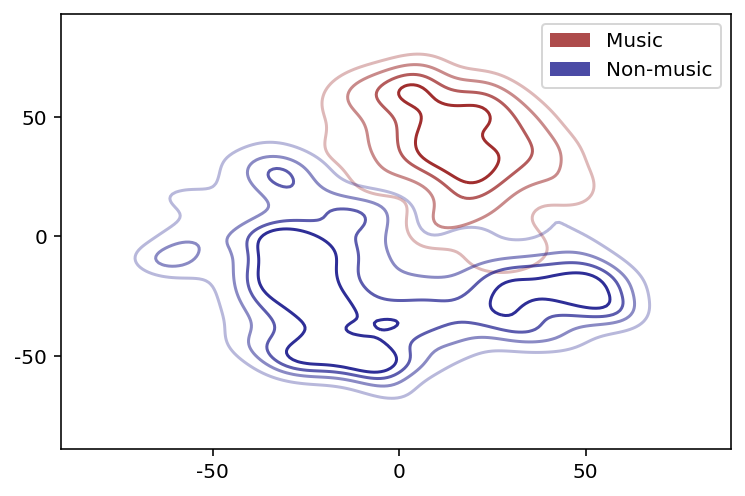

In [29]:
%%time
ismusic = featurevectors[key_test]['ismusic']
isnonmusic = featurevectors[key_test]['isnonmusic']
ismusic_tr = featurevectors[key_train]['ismusic']
isnonmusic_tr = featurevectors[key_train]['isnonmusic']

embeddings = {}
SIstmp = []
fv = featurevectors[key_test]['fv']
tSNE = Pipeline([('scaling', StandardScaler()), ('tSNE', TSNE(n_components=2))])
points = tSNE.fit_transform(fv)
embeddings['method:TSNE, ' + key_test] = points

SI = tSNE_visualization(key_test, ismusic, isnonmusic)


#### tSNE embedding of testset (Checking Music/nonmusic clustering)

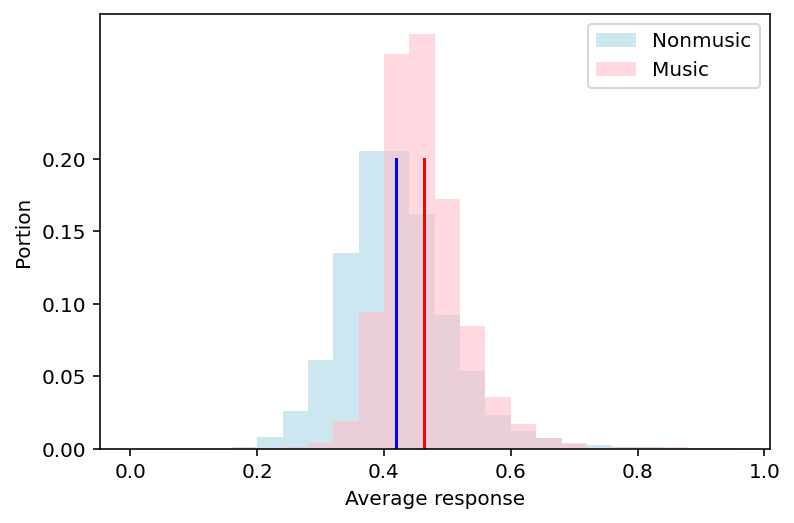

In [23]:
plt.figure()
fv = featurevectors[key_test];
tmp1 = np.mean(fv['fv'][ismusic, :], axis = 1).flatten()
tmp2 = np.mean(fv['fv'][isnonmusic, :], axis=1).flatten()
plt.hist(tmp2, alpha = 0.6, label = 'Nonmusic', weights=np.ones(len(tmp2)) / len(tmp2), bins = np.arange(0,1,0.04), color = 'lightblue')
plt.hist(tmp1, alpha = 0.6, label = 'Music', weights=np.ones(len(tmp1)) / len(tmp1), bins = np.arange(0,1,0.04), color = 'pink')
plt.xlabel('Average response')
plt.ylabel('Portion')
plt.plot([np.mean(tmp1), np.mean(tmp1)], [0, 0.2], color='red')
plt.plot([np.mean(tmp2), np.mean(tmp2)], [0, 0.2], color='blue')
plt.legend()
plt.yticks(np.arange(0, 0.21,0.05))  
plt.xticks(np.arange(0, 1.1, 0.2))
plt.show()

In [24]:
fv = featurevectors[key_train]
featuretmp = fv['fv']
ind1 = ismusic_tr; ind2 = isnonmusic_tr
d1 = featuretmp[ind1, :]; d2 = featuretmp[ind2, :]
m1 = np.mean(d1, axis=0); m2 = np.mean(d2, axis = 0)
s1 = np.std(d1, axis=0); s2 = np.std(d2, axis=0)
t = (m1-m2)/np.sqrt(np.square(s1)/d1.shape[0] + np.square(s2)/d2.shape[0])
# t = (m1-m2)/np.sqrt(np.square(s1) + np.square(s2))
fv['t'] = t
MSI_order = np.argsort(-t)
fv['MSI_order'] = MSI_order


In [26]:
# get music selectivity 
def getMS(fv, ind1, ind2, drawfig, MSI_ind = None):
    featuretmp = fv['fv']
        
    d1 = featuretmp[ind1]; d2 = featuretmp[ind2]
    m1 = np.mean(d1, axis=0); m2 = np.mean(d2, axis = 0)
    s1 = np.std(d1, axis=0); s2 = np.std(d2, axis=0)
    t = (m1-m2)/np.sqrt(np.square(s1)/d1.shape[0] + np.square(s2)/d2.shape[0] )
    fv['t'] = t
    MSI_order = np.argsort(-t)
    fv['MSI_order'] = MSI_order
    if MSI_ind is None:
        MSI_ind = MSI_order[0:32]
    
    fvtmp = np.mean(featuretmp[:,MSI_ind], axis=1)
    data = [fvtmp[ind1], fvtmp[ind2]]
    if drawfig:        
        xlabels = ['Music', 'Nonmusic']
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
        bplot1 = ax1.boxplot(data,
                             sym='',
                             vert=True,  # vertical box alignment
                             patch_artist=True,  # fill with color
                             labels=xlabels)  # will be used to label x-ticks
        ax1.set_title('Rectangular box plot');plt.ylabel('Response');plt.xlabel('Input data')
        colors = ['pink', 'lightblue', 'lightgreen']
        for patch, color in zip(bplot1['boxes'], colors):
            patch.set_facecolor(color)
    return t, MSI_order, data


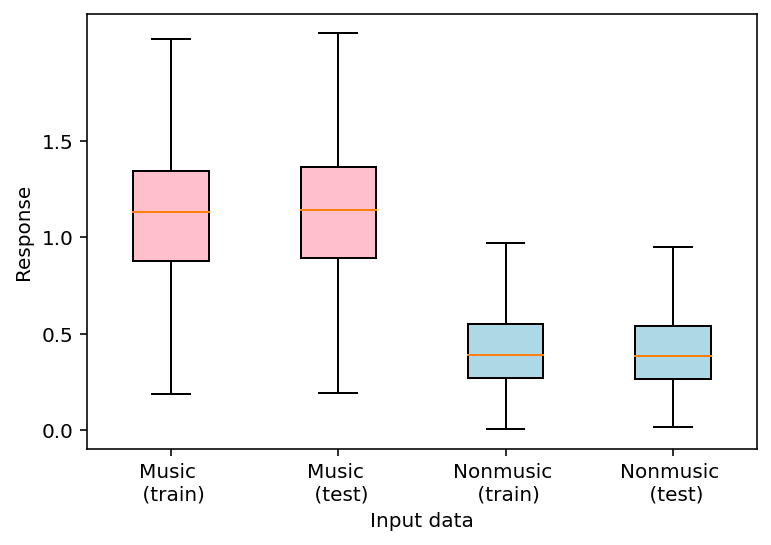

In [33]:
drawfig = False
fv = featurevectors[name_train]; ind1 = fv['ismusic']; ind2 = fv['isnonmusic']
t, MSI_order, data2 = getMS(fv, ind1, ind2, drawfig)    
MSI_ind = MSI_order[0:32]

fv = featurevectors[name_test]; ind1 = fv['ismusic']; ind2 = fv['isnonmusic']
t, MSI_order, data1 = getMS(fv, ind1, ind2, drawfig,  MSI_ind = MSI_ind)     

data = [data1[0], data2[0], data1[1], data2[1]]
xlabels = ['Music \n (train)', 'Music \n (test)', 'Nonmusic \n (train)', 'Nonmusic \n (test)']
fig, ax1 = plt.subplots(nrows=1, ncols=1)
bplot1 = ax1.boxplot(data,
                     sym='',
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=xlabels)  # will be used to label x-ticks
ax1.set_xticklabels(xlabels)  
plt.yticks(np.arange(0, 1.9, 0.5))
plt.ylabel('Response');plt.xlabel('Input data')
colors = ['pink', 'pink','lightblue','lightblue']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)


#### Linear Regression

In [34]:
unitN = 256 # 256 units
names = list(featurevectors.keys())

['data:test, net:trained_nomusic', 'data:train, net:trained_nomusic']


In [42]:
aptmp = np.zeros(8)

fv_tr = featurevectors[key_train]['fv']
fv = featurevectors[key_test]['fv']
MSI_order = featurevectors[key_test]['MSI_order']
usedind_tr = ismusic_tr+isnonmusic_tr
usedind = ismusic+isnonmusic

for ii in np.arange(8):
    k = ii*32
    indrange = np.arange(k, k+32)
    X = fv_tr[:, MSI_order[indrange]][usedind_tr, :]
    y = ismusic_tr[usedind_tr]
    clf = make_pipeline(StandardScaler(),
                        LinearRegression())
    clf.fit(X, y)
    
    X2 = fv[:, MSI_order[indrange]][usedind, :]
    y2 = ismusic[usedind]
    y_test = y2
    y_score = clf.predict(X2)

    ap = average_precision_score(y_test, y_score)
    aptmp[ii] = ap


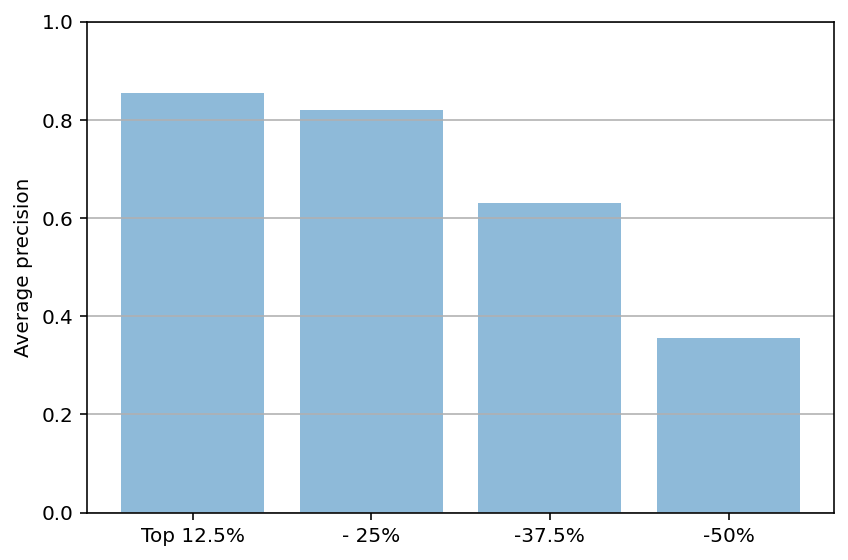

In [47]:
data = [aptmp[0], aptmp[1], aptmp[2], aptmp[3]]#, AP
datalabel = ['Top 12.5%', '- 25%', '-37.5%', '-50%']#, '-67.5%', '-75%', '-87.5%', '-100%']
datamean = [np.mean(d) for d in data]
datastd = [np.std(d) for d in data]
fig, ax = plt.subplots()
x_pos = np.arange(len(datamean))
ax.bar(x_pos, datamean, align='center', alpha=0.5, ecolor='black', capsize=5)
ax.set_ylabel('Average precision')
ax.set_xticks(x_pos)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(datalabel)
ax.yaxis.grid(True)
plt.tight_layout()


### Sound quilt

In [81]:
win_ms = 25 # 25 ms
segment_size_in_win = 16
win_length_smp = floor(win_ms/1000*samplingrate) # win length in sampling number
olap_pts = win_length_smp
max_shift = int(np.floor(win_length_smp/2))
n_seg_total = floor(220500/win_length_smp/segment_size_in_win)
half_olap = int(np.floor(win_length_smp/2))
half_olap_2 = int(olap_pts-half_olap)
hop_pts = win_length_smp*segment_size_in_win # size of segment (30xN)

In [84]:
def reorder_segs(d, hop_pts, order, olap_pts, max_shift):
    shifts = np.zeros((len(order)))

    # pre-initialize output, including overlap beyond end
    y = np.zeros((hop_pts*len(order)+half_olap_2))

    # actual window is the non-overlapping part, plus half an overlap at each end

    win = np.hstack((0.5*(1-np.cos(np.pi*np.arange(olap_pts)/olap_pts)), np.squeeze(np.ones((1, hop_pts-olap_pts))), 0.5*(np.cos(np.pi*np.arange(olap_pts)/olap_pts)+1))) 

    # ramping, plus cross-correlation optimization of alignment

    # We construct the output frame by frame
    # We choose the precise alignment of the next frame by
    # cross-correlating in the overlap region

    # Seed with the first window
    # starting point of frame requested by <order>
    dbase = (order[0])*hop_pts;
    threeqwinix = np.arange(hop_pts+half_olap_2)
    y[threeqwinix] = d[dbase + threeqwinix-1]* win[half_olap+threeqwinix]
    
    # indices of overlap region, relative to first "real" point
    olap_ix = np.arange(-half_olap, half_olap_2)
    # indices of full window, relative to first "real" point
    win_ix  = np.arange(-half_olap, hop_pts+half_olap_2)

    for f in np.arange(1,len(order)):

        # starting point of frame requested by <order>
        dbase = (order[f])*hop_pts;
        # starting point of where it's going to go (ignoring overlap)
        ybase = (f)*hop_pts;
        olap_region = y[ybase+olap_ix];
        # apply second window (that will be applied to final overlap choice)
        olap_region = olap_region*win[0:len(olap_region)];
        # cross-correlate
        # what is the block of candidate overlap points from original signal?

        cand_block = d[dbase+ np.arange((-half_olap-max_shift),(half_olap_2+max_shift))];
        xc = np.convolve(cand_block, np.flipud(olap_region))#/np.sqrt(sum(np.square(olap_region)));  # normalize in case we want to plot

        # Instead, first trim off the ends...
        xc = xc[len(olap_region)+np.arange(0, (1+2*max_shift))];
        # ... then find shift in that part only
        shift = np.where(xc==np.max(xc))[0][0]-max_shift;

        # overlap-add at that point
        op_range = ybase + win_ix;
        overlap_part = win * d[dbase +shift+win_ix]
        y[op_range] = y[op_range] + overlap_part
        shifts[f] = shift
    y = y[0:(len(y)-half_olap_2)]
    return y

In [85]:
## Define mel spectrogram
samplingrate = iter(val_loader).next()[0].shape[2]/10 # samplingrate, total 10 s
winlen = int(np.round(samplingrate*1/40)) # winlen: 25 ms, hoplen: 25 ms
mel_spectrogram2 = nn.Sequential(
    ta.transforms.MelSpectrogram(n_mels=64, sample_rate = samplingrate, win_length = winlen, hop_length = winlen, n_fft = winlen, f_min = 0, f_max = 8000, normalized=False),
    ta.transforms.AmplitudeToDB()
)

In [86]:
win_ms = 25 # 25 ms
win_length_smp = floor(win_ms/1000*samplingrate) # win length in sampling number
olap_pts = win_length_smp
max_shift = int(np.floor(win_length_smp/2))


In [88]:
# get order
def get_feature_soundquilt(model, data_loader, segment_size_in_win):
    with torch.no_grad():
        featuretmp = []
        for inputs, targets in tqdm(data_loader):

            data_torch = inputs[:,:,:].float().to(opt.device)
            outputtmp2 = mel_spectrogram2(inputs.float()).cpu().numpy() # mel-spectrogram data (no modulation)

            if segment_size_in_win !=0:
                
                n_seg_total = floor(220500/win_length_smp/segment_size_in_win)
                half_olap = int(np.floor(win_length_smp/2))
                half_olap_2 = int(olap_pts-half_olap)
                hop_pts = win_length_smp*segment_size_in_win 
                deltacalsize = 2 
                seg_length_smp = hop_pts
                
                for i in np.arange(targets.shape[0]):
                    source_s = data_torch.cpu().numpy()[i,0,:]
                    meltmp = outputtmp2[i, 0, :, :] 
                    deltas = []
                    for j in np.arange(n_seg_total-1):
                        # calculate delta
                        segtmp1 = meltmp[:, (j*segment_size_in_win):((j+1)*segment_size_in_win)] # jth segment of melspectrogram
                        segtmp2 = meltmp[:, ((j+1)*segment_size_in_win):((j+2)*segment_size_in_win)] # j+1th segment of melspectrogram
                        deltatmp = segtmp1[:,(segment_size_in_win-deltacalsize):segment_size_in_win] - \
                        segtmp2[:, 0:deltacalsize]
                        deltas.append(np.sum(deltatmp*deltatmp))

                    soundsample = data_torch[i,0,:].cpu().numpy()
                    s_segments = []  # list of wav segments
                    for k in np.arange(n_seg_total-1):
                        if k ==0:
                            initint = np.random.randint(len(deltas))
                            order = []
                            order.append(initint)
                            delt = np.array(deltas) # delta
                            delk = delt[initint]
                            delt[initint] = np.nan

                        else:
                            tmp = abs(delt - delk) # find idx of similar delta
                            tmp = np.nanargmin(tmp)
                            order.append(tmp)
                            delk = delt[tmp]
                            delt[tmp] = np.nan
                    quilted_s = reorder_segs(source_s, hop_pts, order,  olap_pts, max_shift)
                    datatmp = np.zeros((data_torch.shape[2]))
                    datatmp[0:quilted_s.shape[0]] = quilted_s
                    datatmp[int(220500*0.8):data_torch.shape[2]] = 0
                    data_torch[i,0,:] = torch.from_numpy(datatmp)
            else:
                data_torch[:,:,int(220500*0.8):data_torch.shape[2]] = 0
            x = data_torch.float().to(opt.device)
            features_blobs = {}
            hooks = []
            layers = [LOI]
            for layer in layers:
                m = get_module(model, layer)
                def hook_feature(layer):
                    def _hook(module, input, output):
                        features_blobs[layer] = output.detach().cpu().numpy()
                    return _hook
                hooks.append(m.register_forward_hook(hook_feature(layer)))

            with torch.no_grad():
                model(x)
                for hook in hooks:
                    hook.remove()
            activ = features_blobs[LOI] 
            if len(featuretmp)==0:
                featuretmp = activ
            else:    
                featuretmp = np.concatenate((featuretmp, activ), axis = 0)
        featuretmp = np.squeeze(featuretmp)
        fv = {}
        fv['fv'] = featuretmp
        return fv


In [91]:
%%time
MSI_inds = []
seg_sizes = [0, 2, 4, 8, 16, 32, 64]
y_preds = np.zeros((len(seg_sizes), len(ismusic_tr)))
resptmp2 = np.zeros((len(seg_sizes), len(ismusic_tr), 256))
for ss, segment_size_in_win in enumerate(seg_sizes):

    fv = get_feature_soundquilt(model, train_loader, segment_size_in_win)
    X2 = fv['fv']
    y = ismusic_tr
    resptmp2[ss, :,:] = X2


CPU times: user 57min 27s, sys: 35.8 s, total: 58min 3s
Wall time: 40min 53s


In [92]:
resp_to_music = resptmp2[:,ismusic_tr, :]
resp_to_nonmusic = resptmp2[:,isnonmusic_tr, :]
resps = np.zeros((4, len(seg_sizes)))

name = key_test
MSI_order = featurevectors[name]['MSI_order']
MSI_ind = MSI_order[0:32]
tmp = resp_to_music
tmp = tmp[:,:,MSI_ind]
tmp = np.mean(tmp, axis=1)
tmp = np.mean(tmp, axis=1)
resps[0, :] = tmp

tmp = resp_to_nonmusic
tmp = tmp[:,:,MSI_ind]
tmp = np.mean(tmp, axis=1)
tmp = np.mean(tmp, axis=1)
resps[1, :] = tmp

MSI_ind = MSI_order[-32:]
tmp = resp_to_music[:,:,:]
tmp = tmp[:,:,MSI_ind]
tmp = np.mean(tmp, axis=1)
tmp = np.mean(tmp, axis=1)
resps[2, :] = tmp

tmp = resp_to_nonmusic[:,:,:]
tmp = tmp[:,:,MSI_ind]
tmp = np.mean(tmp, axis=1)
tmp = np.mean(tmp, axis=1)
resps[3, :] = tmp
resp_quilt_dict = {}
resp_quilt_dict['trained_nomusic'] = resps


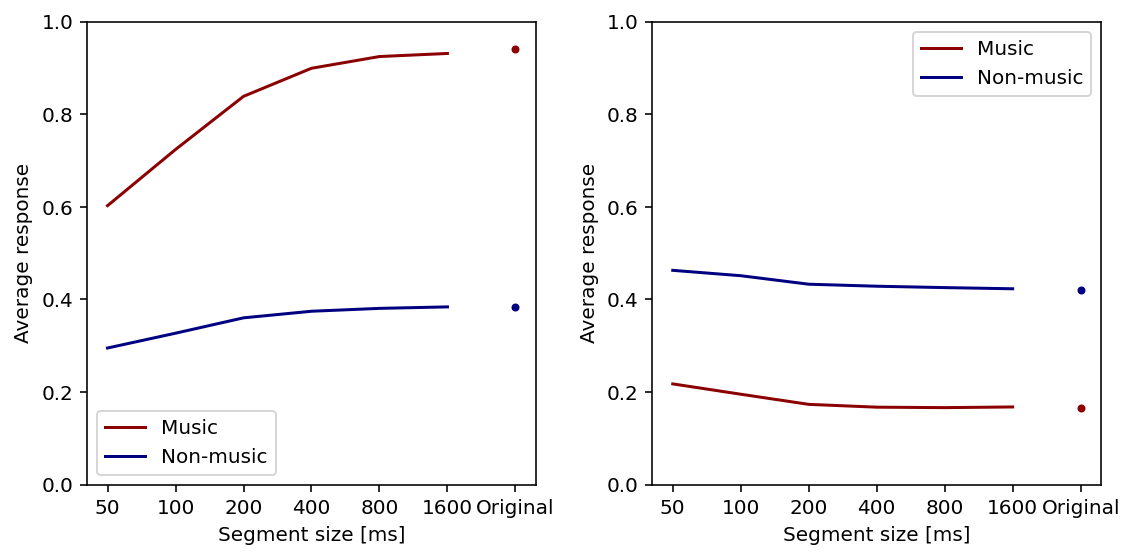

In [113]:
cherryfull = [0.54509804, 0.        , 0.        , 1      ]
sapphirefull = [0.        , 0.        , 0.50196078, 1      ]

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
xrange = np.arange(1,7,1)
xticklabels = (np.array(seg_sizes)[xrange]*25).tolist()
xticklabels.append('Original')
xrangeplot = np.arange(1,8,1)
resptmp = resps[0,:] #np.mean(resptmp2, axis=0)
plt.errorbar(xrange, resptmp[xrange], color = cherryfull, fmt='-', label='Music')

plt.xticks(xrangeplot, xticklabels)
plt.xlabel('Segment size [ms]')
plt.ylabel('Average response')
plt.errorbar(7, resptmp[0], color = cherryfull, fmt='.')

resptmp = resps[1,:] #np.mean(resptmp2, axis=0)
plt.errorbar(xrange, resptmp[xrange], color = sapphirefull, fmt='-', label='Non-music')

plt.xlabel('Segment size [ms]')
plt.ylabel('Average response')
plt.errorbar(7, resptmp[0], color = sapphirefull, fmt='.')
plt.xticks(xrangeplot, xticklabels)
# plt.title('Sound quilt of non-music')
plt.ylim(0, 1.0)
plt.legend()
# plt.show()

plt.subplot(1,2,2)
xticklabels = (np.array(seg_sizes)[xrange]*25).tolist()
xticklabels.append('Original')
xrangeplot = np.arange(1,8,1)
resptmp = resps[2,:] 
plt.errorbar(xrange, resptmp[xrange], color = cherryfull, fmt='-', label='Music')
plt.errorbar(7, resptmp[0], color = cherryfull, fmt='.')

resptmp = resps[3,:]
plt.errorbar(xrange, resptmp[xrange], color = sapphirefull, fmt='-', label='Non-music')
plt.xlabel('Segment size [ms]')
plt.ylabel('Average response')
plt.errorbar(7, resptmp[0], color = sapphirefull, fmt='.')
plt.xticks(xrangeplot, xticklabels)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()


### Ablation test

In [53]:
def Ablation_test(modelused, data_loader, idx_ablation=None): # output: average precision & auc of each class
    if idx_ablation is None:

        evaluator = Evaluator(model=modelused)
        with torch.no_grad():
            test_statistics = evaluator.evaluate(data_loader)
    else:
        hooks = []
        layers = [LOI] # Layers of interest
        for layer in layers:
            m = get_module(modelused, layer)
            def hook_ablation(layer):
                def _hook(module, input, output):
                    output[:, idx_ablation, 0,0] = 0
                return _hook
            hooks.append(m.register_forward_hook(hook_ablation(layer)))
        
        # evaluation of MAP & MAUC
        evaluator = Evaluator(modelused)
        with torch.no_grad():
            test_statistics = evaluator.evaluate(data_loader)
        # removehook
            for hook in hooks:
                hook.remove()
    print('MAP = ' + str(test_statistics['average_precision'].mean()))

    return test_statistics #[test_statistics['average_precision'][label_used].mean(), test_statistics['auc'][label_used].mean()], test_statistics

In [56]:
%%time
Accuracy = {}
N_ablation = 32

name = key_test
if not (name in Accuracy):
    Accuracy[name] = {}
    
# Baseline
Accuracy[name]['Baseline'] = Ablation_test(model, test_loader)

# Ablation based on MSI
fv = featurevectors[name]; 
t = fv['t']
tt = np.argsort(t)
samplingrange_top = np.arange(unitN-1-N_ablation, unitN-1); 
samplingrange_bottom = np.arange(0, N_ablation); 
samplingrange_middle = np.arange((np.int(unitN/2)-np.int(N_ablation/2)), (np.int(unitN/2)+np.int(N_ablation/2)))

Accuracy[name]['MSI bottom '+str(100*N_ablation/256) +'%'] = Ablation_test(model, test_loader, idx_ablation = tt[samplingrange_bottom])
Accuracy[name]['MSI top '+str(100*N_ablation/256) +'%'] = Ablation_test(model, test_loader, idx_ablation = tt[samplingrange_top])
Accuracy[name]['MSI middle '+str(100*N_ablation/256) +'%'] = Ablation_test(model, test_loader, idx_ablation = tt[samplingrange_middle])

# Ablation based on L1norm
n = 1
Lnnorm = np.mean(np.power(abs(featurevectors[name]['fv']), n), axis=0)
tt = np.argsort(Lnnorm) 
samplingrange_top = np.arange(unitN-1-N_ablation, unitN-1); 
Accuracy[name]['L' +str(n) +'norm, top '+str(100*N_ablation/256) +'%'] = Ablation_test(model, test_loader, idx_ablation = tt[samplingrange_top])


MAP = 0.08831940401853805
MAP = 0.0836517896172897
MAP = 0.0703580369951003
MAP = 0.08515772265545049
MAP = 0.07120272412820158
CPU times: user 8min 37s, sys: 14.3 s, total: 8min 51s
Wall time: 7min 37s


In [58]:
averageprecisions = np.zeros((len(list(Accuracy[name].keys())), labelismusic.shape[0])) # iteration x 527 classes
D = Accuracy[name]
for i, key in enumerate(list(D.keys())):
    averageprecisions[i, :] = D[key]['average_precision']

In [63]:
AP = np.mean(averageprecisions[:,~labelismusic], axis=1)
AP.shape

(5,)

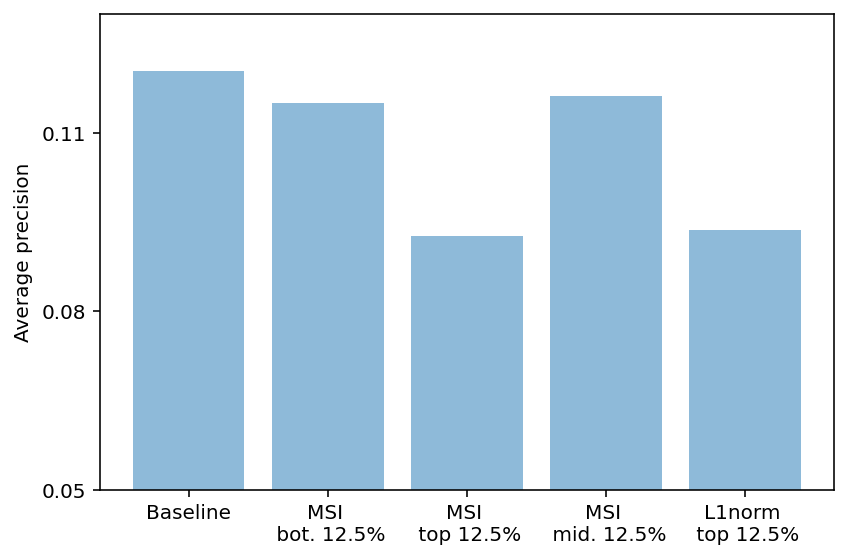

In [66]:

# APs
AP = np.mean(averageprecisions[:,~labelismusic], axis=1)
data = [AP[0], AP[1],AP[2],AP[3],AP[4]]#, AP
datalabel = ['Baseline',
 'MSI \n bot. 12.5%',
 'MSI \n top 12.5%',
 'MSI \n mid. 12.5%',
 'L1norm \n top 12.5%']
datamean = [np.mean(d) for d in data]
datastd = [np.std(d) for d in data]
fig, ax = plt.subplots()
x_pos = np.arange(len(datamean))
ax.bar(x_pos, datamean, align='center', alpha=0.5, ecolor='black', capsize=5)
ax.set_ylabel('Average precision')
ax.set_xticks(x_pos)
ax.set_xticklabels(datalabel)
ax.set_yticks(np.arange(0.05, 0.131, 0.03))
plt.ylim([0.05, 0.13])
plt.tight_layout()


